# Vertical FL

This notebook implements vertical federated learning between 1 coordinator and 2 runners.

## Important papers

#### [Federated Machine Learning: Concept and Applications](https://arxiv.org/pdf/1902.04885.pdf) .

Describes a simplified vertical fl protocol to train a *linear regression* model.

#### [Private federated learning on vertically partitioned data via entity resolution and additively homomorphic encryption](https://arxiv.org/pdf/1711.10677.pdf) .

Describes a vertical fl protocol to train a *binary logistic regression* model using an approximation of the logistic loss and gradient functions. (Implemented here).

#### [A Quasi-Newton Method Based Vertical Federated Learning Framework for Logistic Regression](https://arxiv.org/pdf/1912.00513v2.pdf).

A communication efficient variation of the 2nd paper.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import phe as paillier
from scipy.stats import pearsonr
from time import time

## Homomorphic encryption

Making use of [this](https://github.com/data61/python-paillier) Paillier encyption library. The library also includes encoding of floating point numbers. Note that there are very efficient implementations out there, of which, [NuFHE](https://www.nucypher.com/fully-homomorphic-encryption) (GPU-accelerated fully homomorphic encryption), claims to be the fastest.

In [4]:
pub_key, pri_key = paillier.generate_paillier_keypair(n_length=256)

def encrypt(pub_key, x):
    if pub_key is None:
        return x
    if type(x) is np.ndarray:
        return np.array([pub_key.encrypt(v) for v in x.tolist()])
    elif type(x) is list:
        return [pub_key.encrypt(v) for v in x]
    return pub_key.encrypt(x)

def decrypt(pri_key, x):
    if pri_key is None:
        return x
    if type(x) is np.ndarray:
        return np.array([pri_key.decrypt(v) for v in x])
    elif type(x) is list:
        return [pri_key.decrypt(v) for v in x]
    return pri_key.decrypt(x)

Example: add a non encrypted number (result is encrypted), multiply (aka additive), add 2 encypted numbers.

In [5]:
# [101, 102, 103]
decrypt(pri_key, encrypt(pub_key, np.array([1, 2, 3])) + 100)

# [100, 200, 300]
decrypt(pri_key, encrypt(pub_key, np.array([1, 2, 3])) * 100)

# [2, 4, 6]
decrypt(pri_key, encrypt(pub_key, np.array([1, 2, 3])) + \
        encrypt(pub_key, np.array([1, 2, 3])))

# [140, 100]
x = np.array([[1, 2, 3],[4, 5, 6]])
y = encrypt(pub_key, np.array([10, 20, 30]))
decrypt(pri_key, np.dot([[1, 2, 3], [3, 2, 1]], y))

array([140, 100])

## Loss function

Second order approximation of logistic loss.

$$\ell_H(\theta) \approx \frac{1}{h}\sum_{i \in H}\log2 - \frac{1}{2}y_i\theta^{\top}x_i + \frac{1}{8}(\theta^{\top}x_i)^2$$

This is not necessary for optimisation. Instead, the coordinator will track loss over a test set $H$ - early stopping (when loss begins to climb) can then be used as to prevent model overfitting. This can also be calculated on the runner side.

In [6]:
def taylor_loss(theta, x, y):
    wx = np.dot(x, theta)
    return 1/x.shape[0] * np.sum(np.log(2) - 0.5 * y * wx + 0.125 * wx**2)

## Gradient

For a mini-batch $S'$.

$$\nabla\ell_{S'}(\theta) \approx \frac{1}{s'}\sum_{i \in S'}\left(\frac{1}{4}\theta^{\top}x_i - \frac{1}{2}y_i\right)x_i$$

The approximation is needed since the operations need to be compatible with partial homomorphic encryption (primitive addition and multiplcation by non-encypted number by repeated addition).

In [8]:
def taylor_gradient(theta, x, y):
    return 1/x.shape[0] * np.dot(0.25 * np.dot(x, theta) - 0.5 * y, x)

## Prediction

The learned weights can be plugged into standard logistic function.

In [9]:
def predict_prob(theta, x):
    return 1 / (1 + np.exp(-np.dot(x, theta)))

## algorithm

Some test data:

In [10]:
theta = np.array([1,2,3,4])
x = np.array([[43,33,2,15], [22,1,12,11], [1,2,3,4]])
y = np.array([10,20,30])

The `taylor_gradient` function will produce the following gradients operating over the entire dataset.

In [11]:
taylor_gradient(theta, x, y)

array([670.25      , 426.58333333,  82.33333333, 242.41666667])

Algorithm as described in paper (explanation later). Here, the dataset is vertically partitioned. The resulting gradient matches the gradient over the entire dataset.

In [12]:
a_features = 2
b_features = 2

a_x = x[:,:a_features]
b_x = x[:,b_features:]

# a
a_theta = theta[:a_features]
u = 1/4 * np.dot(a_x, a_theta) - 1/2 * y
u = encrypt(pub_key, u)

# b
b_theta = theta[b_features:]
v = 1/4 * np.dot(b_x, b_theta)
w = u + v
z_b = np.dot(w, b_x)

# a
z_a = np.dot(w, a_x)

# c
z = np.concatenate((z_a, z_b))
z = decrypt(pri_key, z)
1/x.shape[0] * z

array([670.25      , 426.58333333,  82.33333333, 242.41666667])

## Prototype algorithm
First, some metrics to evaluate model predictions.

In [13]:
def metrics(preds, y):
    tp = np.count_nonzero(np.logical_and(y == 1, y == preds))
    fp = np.count_nonzero(np.logical_and(y == 0, y != preds))
    tn = np.count_nonzero(np.logical_and(y == 0, y == preds))
    fn = np.count_nonzero(np.logical_and(y == 1, y != preds))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    tnr = tn / (tn + fp)
    b_acc = (recall + tnr) / 2
    f1 = 2 * precision * recall / (precision + recall)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                pre=round(precision, 2),
                rec=round(recall, 2),
                acc=round(accuracy, 2),
                b_acc=round(b_acc, 2),
                f1=round(f1, 2))

### Vertical FL

#### Runner (A)

* Holds a vertical partition of data. (Note that this has been pre-aligned)
* Holds the binary labels for this data
* Holds a reference/communication channel to Runner (B). Note that in practice, this might be a simple [request-reply](http://zguide.zeromq.org/page:all#Ask-and-Ye-Shall-Receive) pattern.
* Has been issued with a public key (from the coordinator)
* Executes a batch.

In [14]:
class A:
    def __init__(self, x, y, b, pub_key=None):
        self.x = x
        self.y = y
        self.b = b
        self.features = x.shape[1]
        self.pub_key = pub_key
    
    # Called by Coordinator with current model Theta for each mini-batch
    # returns (encrypted) gradients for Runner A, Runner B.
    def gradients(self, theta):
        
        # A's Theta
        a_theta = theta[:self.features]
        
        # A's part of the gradient (result is a 1d vector of length = y)
        u = 1/4 * np.dot(self.x, a_theta) - 1/2 * self.y
        
        # Encrypt (u) using the public key. (result is 1d vector of length = y
        # containing encrypted+encoded values)
        u = encrypt(self.pub_key, u)
        
        # A now sends the thetas and encrypted (u) to Runner B. A "blocks",
        # expecting B to return it's w (needed to complete A's gradient calculation)
        # and B's gradient.
        w, gradient_b = self.b.gradients(theta, u)
        
        # A's gradient
        gradient_a = np.dot(w, self.x)
        
        # Send both parts of (encrypted) gradients to the Coordinator.
        return gradient_a, gradient_b

#### Runner (B)

* Holds a vertical partition of data
* Does *not* contain training labels
* Also issued with the same public key as runner (A) - Not used here, but could be used to encypt loss and send directly to Coordinator.

In [15]:
class B:
    def __init__(self, x, pub_key=None):
        self.x = x
        self.features = x.shape[1]
        self.pub_key = pub_key
    
    # Called by Runner (A) with current model Theta and A's
    # (encypted) part of the gradient calculation.
    def gradients(self, theta, u):
        
        # B's Theta
        b_theta = theta[-self.features:]
        
        # B's part of the gradient (result is a 1d vector of length = A's y)
        v = 1/4 * np.dot(self.x, b_theta)
        
        # Add A's u to B's v.
        # Since u is encrypted, the resulting w is also encrypted.
        w = u + v
        
        # Calculate B's gradient (result is encrypted since dot-product with w)
        gradient_b = np.dot(w, self.x)
        
        # Send back (encypted) w and B gradient to A.
        return w, gradient_b

#### Coordinator (C)

* Holds the complete model $\theta$.
* Issues public keys to Runners A and B
* Executes the outer epoch loop.

In [16]:
class C:
    def __init__(self, a, test_x, test_y, pri_key=None):
        self.a = a
        self.test_x = test_x
        self.test_y = test_y
        self.features = test_x.shape[1]
        self.pri_key = pri_key
        
    def optimise(self, epochs, batch_size, eta, gamma):  
        
        # The global model. Theta = [A's Theta | B's Theta]
        theta = np.zeros(self.features)
        loss = []
        
        for epoch in range(0, epochs):
            
            # Coordinator requests Runner A to calculate gradients for a batch.
            # This is a blocking call, resulting in (encypted) gradient vectors from A and B.
            gradient_a, gradient_b = self.a.gradients(theta)
            
            # Concatenate the gradients to match length of Theta
            gradients = np.concatenate((gradient_a, gradient_b))
            
            # Decrypt the gradients (using private key)
            gradients = decrypt(self.pri_key, gradients)
            
            # Normalise (although this could be done runner side.)
            gradients = 1/batch_size * gradients
            
            # Update the model weights. (assumes weight 0 = bias)
            # Gamma = regularisation parameter.
            theta = theta - (eta * (gradients + gamma*theta))
            
            # Calculate the loss (using a hold out test set.)
            # We could stop training here if the loss begins to climb
            # (early-stopping to avoid overfitting)
            loss.append(taylor_loss(theta, self.test_x, self.test_y))
            
        return theta, loss

### Security

In this setup:

* Coordinator sends (plain-text) Theta to Runner A, receives (encypted) gradients from Runner A.
* Runner B can not see A's part of the gradient calculation (which includes A's Theta*X), it uses the encypted part in it's own calculations.
* Runner A can not see B's part of the gradient calculation.
* Data never leaves runners.
* Most sensitive part is transfer of encrypted gradients which are derived from Theta,X,y dot products.

## Demo

In [17]:
df = pd.read_csv('data/breast.csv')
df.head()

,id,y,x0,x1,x2,x3,x4,x5,x6,x7,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29
0,133,1,0.254879,-1.046633,0.209656,0.074214,-0.441366,-0.377645,-0.485934,0.347072,...,-0.337360,-0.728193,-0.442587,-0.272757,-0.608018,-0.577235,-0.501126,0.143371,-0.466431,-0.554102
1,273,1,-1.142928,-0.781198,-1.166747,-0.923578,0.628230,-1.021418,-1.111867,-0.959523,...,-0.493639,0.348620,-0.552483,-0.526877,2.253098,-0.827620,-0.780739,-0.376997,-0.310239,0.176301
2,175,1,-1.451067,-1.406518,-1.456564,-1.092337,-0.708765,-1.168557,-1.305831,-1.745063,...,-0.666881,-0.779358,-0.708418,-0.637545,0.710369,-0.976454,-1.057501,-1.913447,0.795207,-0.149751
3,551,1,-0.879933,0.420589,-0.877527,-0.780484,-1.037534,-0.483880,-0.555498,-0.768581,...,-0.451772,0.453852,-0.431696,-0.494754,-1.182041,0.281228,0.084759,-0.252420,1.038575,0.351054
4,199,0,0.426758,0.723479,0.316885,0.287273,1.000835,0.962702,1.077099,1.053586,...,-0.707304,-1.026834,-0.702973,-0.460212,-0.999033,-0.531406,-0.394360,-0.728830,-0.644416,-0.688003


In [18]:
df.shape

(569, 32)

In [19]:
m = df.to_numpy()
x = m[:,2:]
y = m[:,1]
x = np.append(np.ones((x.shape[0], 1)), x, axis=1) # add bias column
n_features = x.shape[1]
n_features

31

Note that in paper $y_i^2 \forall i$.

In [20]:
yy = y.copy()
yy[yy==0] = -1

In [21]:
pub_key, pri_key = paillier.generate_paillier_keypair(n_length=256)

a_features = 16 # leaving 15 for B.

epochs = 100
eta = 0.1
gamma = 0

# Full gradient descent (aka full batch)
batch_size = x.shape[0]

# A's partition
A_x = x[:,:a_features]

# B's partition
B_x = x[:,a_features:]

# Initialse Runner B with partition of data.
b = B(B_x, pub_key)

# Initialise Runner A with parition of data, training labels and reference to B.
a = A(A_x, yy, b, pub_key)

# Initialise Coordinator C with reference to Runner A.
# Note that test_x, test_y would usually be a seperate hold-out test-set.
c = C(a, test_x=x, test_y=yy, pri_key=pri_key)

# Optimise a model.
vertical_model, loss = c.optimise(epochs, batch_size, eta, gamma)

np.set_printoptions(suppress=True)
vertical_model

array([ 0.46913881, -0.19094578, -0.17937773, -0.15553755, -0.07897883,
       -0.17110835, -0.0707345 , -0.14143548, -0.23301292, -0.18134269,
       -0.10780117, -0.13906282, -0.1314339 , -0.12566135, -0.06440545,
       -0.02087393,  0.04032803, -0.07835199, -0.1637014 , -0.01596616,
        0.13314217, -0.10549515, -0.00756715, -0.02932199,  0.06262868,
       -0.06803751,  0.09673001,  0.09003868, -0.09642666, -0.00043795,
        0.04499929])

Loss observed during training.

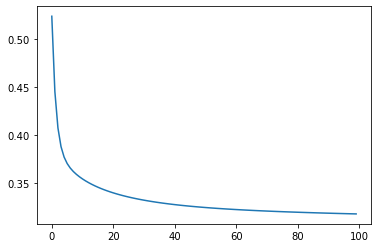

In [22]:
sns.lineplot(x=range(0, len(loss)), y=loss)

As an experiment, generate a model using the entire dataset and a binary logistic classifier.

In [23]:
from sklearn import linear_model
model = linear_model.SGDClassifier(loss='log', learning_rate='constant', eta0=eta, verbose=0, max_iter=1000)
model.fit(x[:,1:], y)
print(model.intercept_)
print(model.coef_)

[0.201813]
[[-1.45287682 -1.85818508 -1.20746532 -1.38665496 -0.86492802 -0.11907147
  -0.98682671 -1.38768681 -1.69585597 -0.72591401 -0.57744905 -0.39146198
  -0.56540467 -0.63920905 -0.45870082  0.67386586 -1.06658774 -1.36812051
   0.21745875  0.52358789 -1.94387692  0.45895277 -1.12447249 -1.49149303
  -0.93202742  1.05340374  0.89524263 -0.52435174  0.22080829  0.82125417]]


Visualise the weights obtained from vertical model.

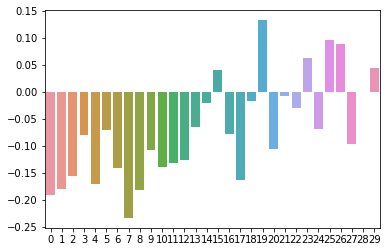

In [24]:
sns.barplot(x=list(range(0, n_features-1)), y=vertical_model[1:])

Visualise the weights obtained from the standard model.

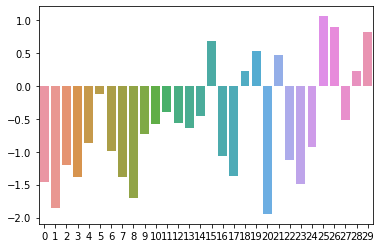

In [25]:
sns.barplot(x=list(range(0, n_features-1)), y=model.coef_[0])

The weights are similar, indicating that both models have converged to similar hypothesis.

In [26]:
print("pcc = {:.2f} p = {:.4f} ".format(*pearsonr(vertical_model[1:], model.coef_[0])))

pcc = 0.75 p = 0.0000 


Vertical model performance

In [27]:
print(metrics((predict_prob(vertical_model, x) > 0.5).astype(int), y))

{'tp': 356, 'fp': 19, 'tn': 193, 'fn': 1, 'pre': 0.95, 'rec': 1.0, 'acc': 0.96, 'b_acc': 0.95, 'f1': 0.97}


Standard model performance

In [28]:
print(metrics(model.predict(x[:,1:]), y))

{'tp': 356, 'fp': 6, 'tn': 206, 'fn': 1, 'pre': 0.98, 'rec': 1.0, 'acc': 0.99, 'b_acc': 0.98, 'f1': 0.99}


### Encryption overhead

In [94]:
epochs = 10

times = []
for k in [None, 256, 512, 1024, 2048]:

    pub_key, pri_key = paillier.generate_paillier_keypair(n_length=k) if k is not None else (None, None)
    
    b = B(B_x, pub_key)
    a = A(A_x, yy, b, pub_key)
    c = C(a, test_x=x, test_y=yy, pri_key=pri_key)
    t = time()
    print("key size = {}".format(k))
    c.optimise(epochs, batch_size, eta, gamma)
    
    times.append(time() - t)

print(times)

key size = None
key size = 256
key size = 512
key size = 1024
key size = 2048
[0.0012736320495605469, 23.895406484603882, 70.28749990463257, 236.19560885429382, 979.9899735450745]


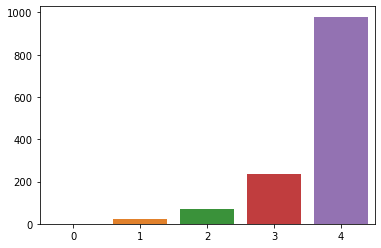

In [95]:
sns.barplot(x=list(range(0, 5)), y=times)